In [98]:
import pandas as pd
import numpy as np
import os
import lightgbm as lgb
import re
import matplotlib.pyplot as plt
import shap
from datetime import date
import chart_studio.plotly as py
import plotly.graph_objects as go

from utils import *
from sklearn.model_selection import train_test_split

In [21]:
DEFAULT_PATH = os.path.join(os.path.abspath('..'))
DEFAULT_OUTPUT = DEFAULT_PATH + "/data/Bike-Sharing-Dataset/hour.csv"

In [22]:
cols = ['dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt']

In [23]:
df_bike_hourly = pd.read_csv(DEFAULT_OUTPUT, parse_dates=['dteday'], usecols=cols)

## Data Info

In [24]:
df_bike_hourly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 16 columns):
dteday        17379 non-null datetime64[ns]
season        17379 non-null int64
yr            17379 non-null int64
mnth          17379 non-null int64
hr            17379 non-null int64
holiday       17379 non-null int64
weekday       17379 non-null int64
workingday    17379 non-null int64
weathersit    17379 non-null int64
temp          17379 non-null float64
atemp         17379 non-null float64
hum           17379 non-null float64
windspeed     17379 non-null float64
casual        17379 non-null int64
registered    17379 non-null int64
cnt           17379 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(11)
memory usage: 2.1 MB


## Data Sample

In [25]:
df_bike_hourly.head()

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Missing Values

In [26]:
display_all(df_bike_hourly.isnull().sum().sort_index()/len(df_bike_hourly))

atemp         0.0
casual        0.0
cnt           0.0
dteday        0.0
holiday       0.0
hr            0.0
hum           0.0
mnth          0.0
registered    0.0
season        0.0
temp          0.0
weathersit    0.0
weekday       0.0
windspeed     0.0
workingday    0.0
yr            0.0
dtype: float64

## Data Summary

In [27]:
display_all(df_bike_hourly.describe(include='all').T)

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
dteday,17379,731,2012-08-29 00:00:00,24,2011-01-01 00:00:00,2012-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
season,17379,NaN,NaN,NaN,NaN,NaN,2.50164,1.10692,1,2,3,3,4
yr,17379,NaN,NaN,NaN,NaN,NaN,0.502561,0.500008,0,0,1,1,1
mnth,17379,NaN,NaN,NaN,NaN,NaN,6.53778,3.43878,1,4,7,10,12
hr,17379,NaN,NaN,NaN,NaN,NaN,11.5468,6.91441,0,6,12,18,23
holiday,17379,NaN,NaN,NaN,NaN,NaN,0.0287704,0.167165,0,0,0,0,1
weekday,17379,NaN,NaN,NaN,NaN,NaN,3.00368,2.00577,0,1,3,5,6
workingday,17379,NaN,NaN,NaN,NaN,NaN,0.682721,0.465431,0,0,1,1,1
weathersit,17379,NaN,NaN,NaN,NaN,NaN,1.42528,0.639357,1,1,1,2,4
temp,17379,NaN,NaN,NaN,NaN,NaN,0.496987,0.192556,0.02,0.34,0.5,0.66,1


In [28]:
def get_dummies(df, column_name):
    return pd.get_dummies(df, columns=column_name)

## Preprocessing Data

In [85]:
ls_cols_useful = ['dteday', 'season', 'yr', 'mnth', 'hr', 
            'holiday', 'weekday', 'workingday', 'weathersit', 
            'temp', 'atemp', 'hum', 'windspeed', 'cnt']
df_train_hourly = (pd.read_csv(DEFAULT_OUTPUT, usecols=ls_cols_useful, parse_dates=['dteday'])
                     .pipe(add_datepart, 'dteday', drop=False, ret=True)
                     #.pipe(get_dummies, ['weathersit'])
                     #.assign(weathersit=lambda x: x.weathersit.astype('category'))
                     #.assign(season=lambda x: x.season.astype('category'))
                     #.assign(random=lambda x: np.random.random(size=len(x)))
                     .assign(temp=lambda x: (47*x.temp-8))
                     .assign(atemp=lambda x: (66*x.atemp-16))
                     .assign(hum=lambda x: x.hum*100)
                     .assign(windspeed=lambda x: x.windspeed*67)
                     .sort_values(by=['dteday', 'hr'])
                     .set_index(['dteday', 'hr'], drop=False))

## Train Test Split

In [30]:
ls_remove_cols = ['cnt', 'dtedayDayofyear', 'dtedayYear', 'dtedayIs_quarter_end',
       'dtedayYear', 'dtedayMonth', 'dtedayWeek', 'dtedayDay',
       'dtedayDayofweek', 'dtedayDayofyear', 'dtedayIs_month_end',
       'dtedayIs_month_start','dtedayIs_quarter_end', 'dteday',
       'dtedayIs_quarter_start', 'dtedayIs_year_end', 'dtedayIs_year_start',
       'dtedayElapsed']#,'holiday']
TRAIN_FEATURES = [i for i in df_train_hourly.columns if i not in ls_remove_cols]
TARGET_FEATURE = ['cnt']

In [31]:
X_train, X_val, y_train, y_val = train_test_split(
                                    df_train_hourly[TRAIN_FEATURES], 
                                    df_train_hourly[TARGET_FEATURE],
                                    test_size=0.20, 
                                    shuffle=False,
                                    random_state=42)

## Model Training

In [34]:
params = {
   'nthread': 4,
   'max_depth': 5,
   'task': 'train',
   'boosting_type': 'gbdt',
   'objective': 'regression_l1',
   'metric': 'mape', # this is abs(a-e)/max(1,a)
   'num_leaves': 50,
   'learning_rate': 0.1,
   'min_data_in_leaf': 250,
   'verbose': 1
    }

In [43]:
%%time
lgb_train = lgb.Dataset(X_train, y_train)
lgb_valid = lgb.Dataset(X_val,y_val)
lgbm = lgb.train(params, lgb_train, 5000, 
                  valid_sets=[lgb_train, lgb_valid], 
                  early_stopping_rounds=50, 
                  verbose_eval=50)

Training until validation scores don't improve for 50 rounds.
[50]	training's mape: 0.457883	valid_1's mape: 0.452094
[100]	training's mape: 0.402644	valid_1's mape: 0.415924
[150]	training's mape: 0.383926	valid_1's mape: 0.396043
[200]	training's mape: 0.375268	valid_1's mape: 0.380676
[250]	training's mape: 0.369109	valid_1's mape: 0.379099
[300]	training's mape: 0.360968	valid_1's mape: 0.366686
[350]	training's mape: 0.357932	valid_1's mape: 0.361439
[400]	training's mape: 0.353267	valid_1's mape: 0.362124
Early stopping, best iteration is:
[389]	training's mape: 0.353454	valid_1's mape: 0.360651
CPU times: user 3.08 s, sys: 31.2 ms, total: 3.11 s
Wall time: 972 ms


## Model Evaluation

In [80]:
df_graph = (pd.DataFrame(zip(lgbm.predict(X_val), y_val.cnt),
                        columns=['prediction', 'actual'],
                        index = X_val.index)
              .reset_index()
              .assign(date=lambda x: pd.to_datetime(x.dteday))
              .assign(time=lambda x: pd.to_timedelta(x.hr, unit='h'))
              .assign(date_time=lambda x: x.date + x.time))

In [84]:
fig = go.Figure()
actual  = go.Scatter(
                x=df_graph.date_time,
                y=df_graph['actual'],
                name="actual",
                line_color='grey',
                opacity=0.8)

prediction = go.Scatter(
                 x=df_graph.date_time,
                 y=df_graph['prediction'],
                 name="prediction",
                 line_color='deepskyblue',
                 opacity=0.8)
data = [actual, prediction]

layout = dict(
    title='Actual Vs Prediction',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = False
        ),
        #type='date'
    )
)

fig = dict(data=data, layout=layout)
py.iplot(fig, filename = "Time Series with Rangeslider")

## Feature Importance

In [87]:
shap_values = shap.TreeExplainer(lgbm).shap_values(X_train)

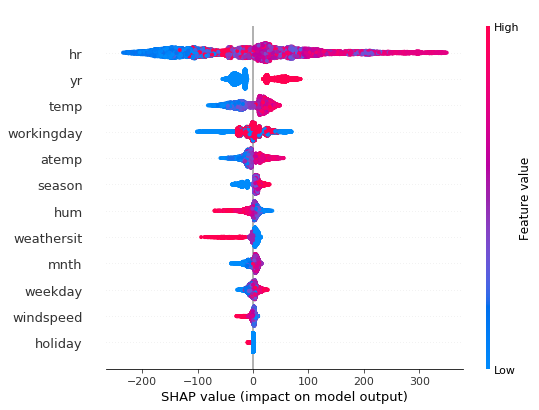

In [88]:
shap.summary_plot(shap_values, X_train)

## Partial Dependence Plots

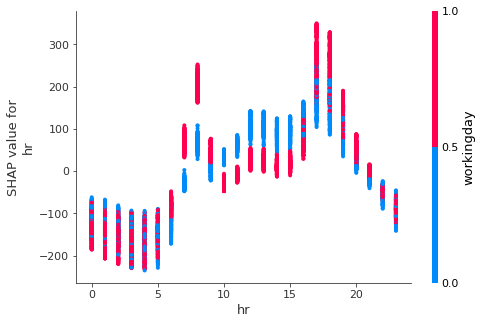

In [89]:
shap.dependence_plot('hr', shap_values, X_train.values, feature_names=X_train.columns)

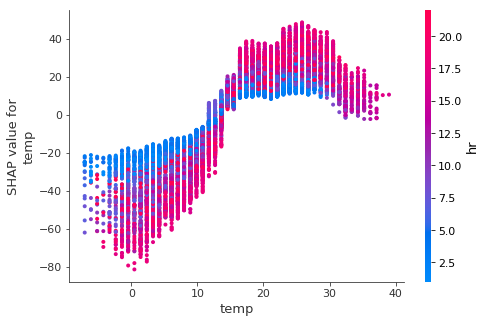

In [90]:
shap.dependence_plot('temp', shap_values, X_train.values, feature_names=X_train.columns)

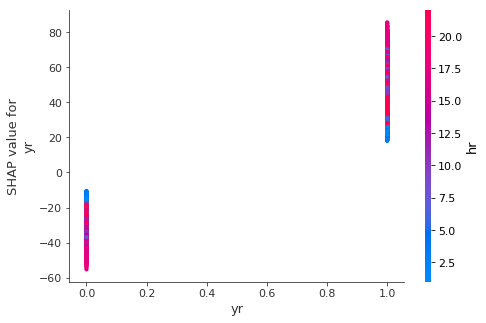

In [91]:
shap.dependence_plot('yr', shap_values, X_train.values, feature_names=X_train.columns)

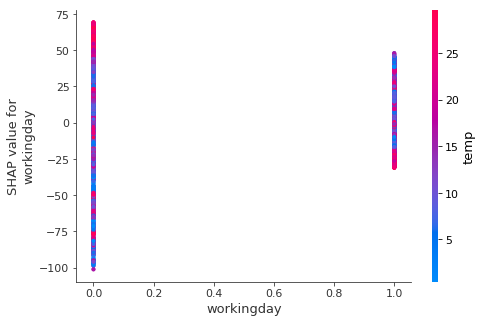

In [92]:
shap.dependence_plot('workingday', shap_values, X_train.values, feature_names=X_train.columns)

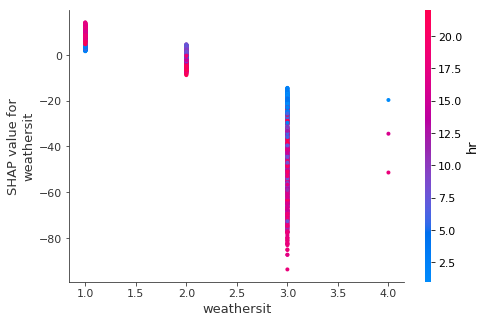

In [93]:
shap.dependence_plot('weathersit', shap_values, X_train.values, feature_names=X_train.columns)

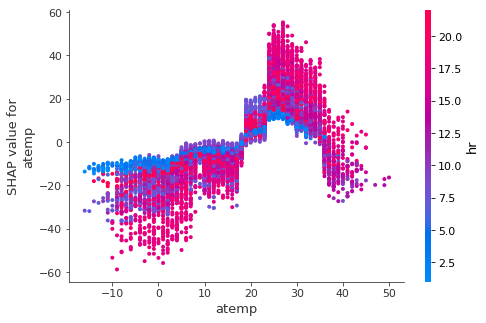

In [94]:
shap.dependence_plot('atemp', shap_values, X_train.values, feature_names=X_train.columns)

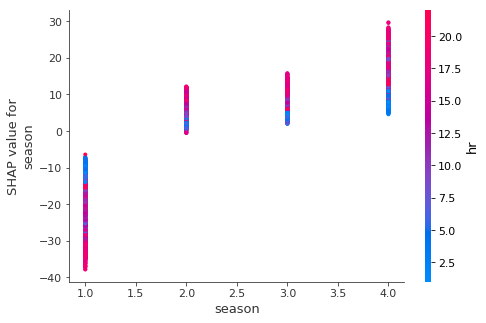

In [95]:
shap.dependence_plot('season', shap_values, X_train.values, feature_names=X_train.columns)

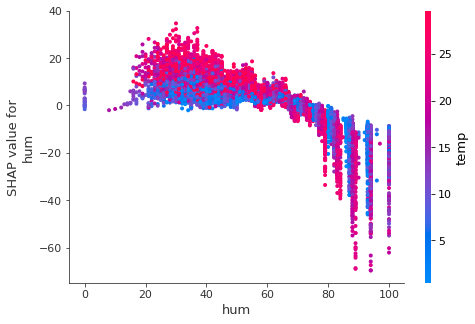

In [96]:
shap.dependence_plot('hum', shap_values, X_train.values, feature_names=X_train.columns)

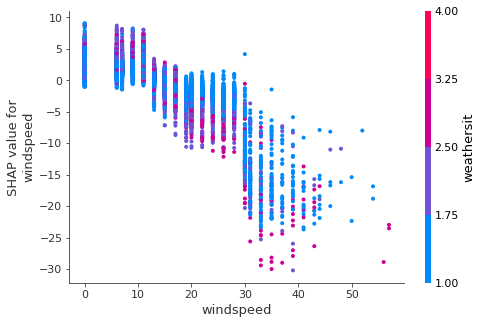

In [97]:
shap.dependence_plot('windspeed', shap_values, X_train.values, feature_names=X_train.columns)